In [136]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import random_split
from tqdm import tqdm
import torch.nn.functional as F
import ignite.contrib.metrics

In [137]:
df = pd.read_csv(r'train.csv')

In [138]:
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
df_img = df.drop('label', axis=1)
df_label = df['label'].values

In [140]:
type(df_label)

numpy.ndarray

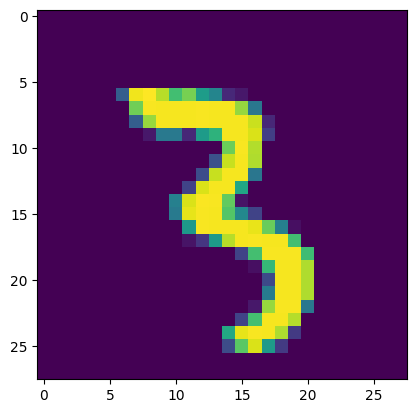

In [141]:
import matplotlib.pyplot as plt

arr_0 = df_img.iloc[28002].values.reshape((28,28))
plt.imshow(arr_0)

class Dataset (read row by index => make an image) -> dataloader -> model -> training loop -> evaluation loop -> perfecto

In [142]:
class Dataset(torch.utils.data.Dataset):
   def __init__(self,data_images,labels):
      self.raw_images = data_images
      self.labels = labels
   
   def __getitem__(self,index):
      item = df_img.iloc[index].values.reshape((28,28))
      return torch.from_numpy(item), self.labels[index]


   def __len__(self):
      return len(self.raw_images)

    

In [143]:
from torch.utils.data import DataLoader
from ignite.engine import  Engine

In [144]:
train_dataset = Dataset(df_img,df_label)
train_size = int(len(train_dataset) * 0.9)
val_size = len(train_dataset) - train_size
training_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
batch_size_number = 16
train_loader = DataLoader(training_dataset, batch_size=batch_size_number,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_number,shuffle=False)

In [145]:
next(iter(train_loader))

[tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0

In [146]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
class NN_custom(torch.nn.Module):
    def __init__(self, activ_function):
        super().__init__()
        self.model_layers = torch.nn.Sequential(
            # torch.nn.Conv2d(in_channels=1,out_channels=32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)),
            torch.nn.Conv2d(in_channels=1,out_channels=32, kernel_size = 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32,out_channels=32, kernel_size = 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32,out_channels=32, kernel_size = 5, stride=2, padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),

            torch.nn.Conv2d(in_channels=32,out_channels=64, kernel_size = 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64,out_channels=64, kernel_size = 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64,out_channels=64, kernel_size = 5, stride=2, padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(in_channels=64,out_channels=128, kernel_size = 4),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Flatten(),
        )
        self.activation_function = activ_function
        # self.sofmax = torch.nn.Softmax(dim=1)
        self.linear = torch.nn.Linear(in_features=128, out_features=10)

    def forward(self, input_images: torch.Tensor):
        x = input_images
        for layer in self.model_layers:
            x = layer(x)
            # x = self.activation_function(x)
        x = self.linear(x)
        # x = self.sofmax(x)
        return x

In [147]:
from sklearn.metrics import roc_auc_score


def ROCAUC(x, y):
    total = 0
    counter = 0
    x = x.clone().detach().cpu().numpy()
    y = y.clone().detach().cpu().numpy()
    for index, sample in enumerate(x):
        sub_score = roc_auc_score(y[index], sample)
        total += sub_score
        counter += 1
    return total / counter

In [148]:
import time

In [149]:
def training_step(network,optimizer,data,targets,device):
    optimizer.zero_grad()
    output = network(data.float().view(-1,1,28,28)).to(device=device)

    softmax_ = torch.nn.Softmax(dim=1)
    output_soft = softmax_(output)
    # output_bool = output_soft >= 0.5

    # for index,sample in enumerate(output_bool):
    #     if True in sample:
    #         output_encoded = output_bool.long()
    #     else:
    #         max_indic = torch.argmax(output_soft[index])
    #         sample[max_indic] = True
    # output_encoded = output_bool.long()

    targets = F.one_hot(targets, num_classes = 10).float()
    loss = F.cross_entropy(output, targets)

    
    # loss.requires_grad = True

    loss.backward()
    optimizer.step()
    return loss.item()


def val_step(network,data,targets,device):
    with torch.no_grad():
        output = network(data.float().view(-1,1,28,28)).to(device=device)
        
        softmax_ = torch.nn.Softmax(dim=1)
        output = softmax_(output)

        targets = F.one_hot(targets, num_classes = 10).float()

        roc_auc = ROCAUC(output, targets)

        # print("____________________________--")
        # print(output.shape,"=",targets.shape)
        # print("____________________________--")

        # state = default_evaluator.run([[output, targets]])

        return roc_auc

In [150]:
def training_loop(
        network: torch.nn.Module,
        train_loader,
        val_loader,
        num_epochs: int,
        optimizer,
        show_progress: bool = True) -> tuple[list, list]:
    
    device = torch.device("cuda")
    if not torch.cuda.is_available():
        print("CUDA IS NOT AVAILABLE")
        device = torch.device("cpu")
    
    

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

    train_losses = []
    eval_losses = []

    for epoch in tqdm(range(num_epochs), desc="Epoch", position=0, disable=not show_progress):

        network.train()
        epoch_train_losses = []

        for information in tqdm(train_loader, desc="Minibatch", position=1, leave=False, disable=not show_progress):
            data,targets = information
            data = data.to(device=device)
            targets = targets.to(device=device)
            loss = training_step(network,optimizer,data,targets,device)
            epoch_train_losses.append(loss)
        train_losses.append(torch.mean(torch.tensor(epoch_train_losses)))
        
        network.eval()

        epoch_eval_losses = []
        for information in val_loader:
            data,targets = information
            data = data.to(device=device)
            targets = targets.to(device=device)
            loss = val_step(network,data,targets,device)
            epoch_eval_losses.append(loss)
        eval_losses.append(torch.mean(torch.tensor(epoch_eval_losses)))

        # scheduler.step()
        print('\n',torch.mean(torch.tensor(epoch_train_losses)),"\t<- Train|Eval ->",torch.mean(torch.tensor(epoch_eval_losses)),'\n')
        
        # Early stopping
        if np.argmin(eval_losses) <= epoch - 4:
            break
            
    return network, train_losses, eval_losses

In [151]:
device = torch.device("cuda")
if not torch.cuda.is_available():
    print("CUDA IS NOT AVAILABLE")
    device = torch.device("cpu")

print("DEV1CE",device)
network = NN_custom(torch.nn.ReLU(inplace=False)).to(device)

optimizer = torch.optim.AdamW(network.parameters(), lr=0.001)
network_final, train_losses, eval_losses = training_loop(network, train_loader, val_loader, 10, optimizer)

DEV1CE cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  10%|█         | 1/10 [00:32<04:53, 32.60s/it]


 tensor(0.1209) 	<- Train|Eval -> tensor(0.9983, dtype=torch.float64) 



Epoch:  20%|██        | 2/10 [01:03<04:15, 31.89s/it]


 tensor(0.0574) 	<- Train|Eval -> tensor(0.9984, dtype=torch.float64) 



Epoch:  30%|███       | 3/10 [01:33<03:34, 30.58s/it]


 tensor(0.0450) 	<- Train|Eval -> tensor(0.9987, dtype=torch.float64) 



Epoch:  40%|████      | 4/10 [02:02<03:00, 30.00s/it]


 tensor(0.0347) 	<- Train|Eval -> tensor(0.9987, dtype=torch.float64) 



Epoch:  40%|████      | 4/10 [02:32<03:48, 38.14s/it]


 tensor(0.0300) 	<- Train|Eval -> tensor(0.9985, dtype=torch.float64) 



In [152]:
for train_data, target in train_loader:
    res = network(train_data.float().view(-1,1,28,28).to("cuda"))
    softmax_ = torch.nn.Softmax(dim=1)
    res = softmax_(res)
    for i in res:
        print(torch.argmax(i))
    print(target)
    # plt.imshow(train_data[0].detach().cpu().numpy())
    # print(train_data, target)
    break

tensor(9, device='cuda:0')
tensor(5, device='cuda:0')
tensor(4, device='cuda:0')
tensor(5, device='cuda:0')
tensor(9, device='cuda:0')
tensor(6, device='cuda:0')
tensor(2, device='cuda:0')
tensor(9, device='cuda:0')
tensor(8, device='cuda:0')
tensor(0, device='cuda:0')
tensor(8, device='cuda:0')
tensor(8, device='cuda:0')
tensor(0, device='cuda:0')
tensor(4, device='cuda:0')
tensor(9, device='cuda:0')
tensor(2, device='cuda:0')
tensor([9, 5, 4, 5, 9, 6, 2, 9, 8, 0, 8, 8, 0, 4, 9, 2])


In [153]:
test_df = pd.read_csv(r'test.csv')

In [154]:
test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
class DatasetTest(torch.utils.data.Dataset):
   def __init__(self,data_images_):
      self.raw_images = data_images_
   
   def __getitem__(self,index):
      item = self.raw_images.iloc[index].values.reshape((28,28))
      return torch.from_numpy(item)

   def __len__(self):
      return len(self.raw_images)

In [156]:
print(torch.cuda.get_device_name(0))

GeForce GTX 1660 Ti


In [164]:
test_dataset = DatasetTest(test_df)

In [158]:
print(len(test_dataset))

28000


  0%|          | 67/28000 [00:00<02:00, 231.82it/s]

9


100%|██████████| 28000/28000 [01:19<00:00, 350.48it/s]


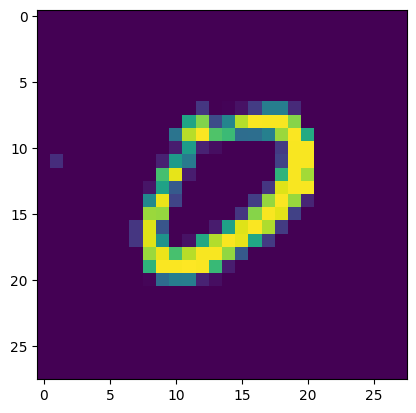

In [166]:
df_dict_ = {'ImageId': [], 'Label': []}
for ind in tqdm(range(0, 28000)):
    item_ = test_dataset[ind]
    prediction = network(item_.float().view(-1,1,28,28).to("cuda"))
    softmax_ = torch.nn.Softmax(dim=1)
    prediction = softmax_(prediction)
    label = torch.argmax(prediction)
    
    df_dict_['ImageId'].append(ind+1)
    df_dict_['Label'].append(label.item())

    if (ind+1) == 4:
        plt.imshow(item_.reshape((28,28)))
        print(label.item())
    #     break

In [167]:
out_df_ = pd.DataFrame(df_dict_)

In [168]:
out_df_

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [169]:
out_df_.to_csv('./preds.csv', sep=',', index=False)

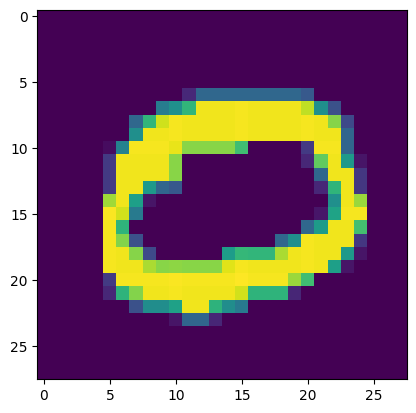

In [172]:
arr_0 = test_df.iloc[1].values.reshape((28,28))
plt.imshow(arr_0)